In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from tqdm import tqdm
import joblib
import shap

# Load and Clean Data

In [28]:
matches = pd.read_csv('matches_1930_2022_post_feat_engineering.csv')
test = matches[matches['Year'] == 2022]
y_test_gs = []
gs = test[test['Stage'].str.contains('Group')]
for index, i in enumerate(gs['Home Team Goals'].tolist()):
    at = gs['Away Team Goals'].tolist()[index]
    if i > at:
        y_test_gs.append(0)
    elif i == at:
        y_test_gs.append(1)
    else:
        y_test_gs.append(2)
        
ko = test[~test['Stage'].str.contains('Group')]
y_test_ko = []
for index, i in enumerate(ko['Home Team Goals'].tolist()):
    at = ko['Away Team Goals'].tolist()[index]
    if i > at:
        y_test_ko.append(0)
    elif at < i:
        y_test_ko.append(1)
    else:
        ht = ko['Home Team Name'].tolist()[index]
        if ht in ko['Win conditions'].tolist()[index]:
            y_test_ko.append(0)
        else:
            y_test_ko.append(1)
test.shape

(64, 113)

# Load Models

In [29]:
#Load models here
group_stage_model = joblib.load('Group_Stage_model_full_opt.pkl')
print('Group Stage Model:', group_stage_model)
print()
ko_stage_model = joblib.load('KO_round_model_full_opt.pkl')
print('KO Model:', ko_stage_model)

Group Stage Model: GradientBoostingClassifier(ccp_alpha=0.0004, max_features=9, random_state=88)

KO Model: GradientBoostingClassifier(ccp_alpha=0.00030000000000000003, max_features=5,
                           random_state=88)


# Plot Feature Importance Visualizations

Using 1374 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/48 [00:00<?, ?it/s]

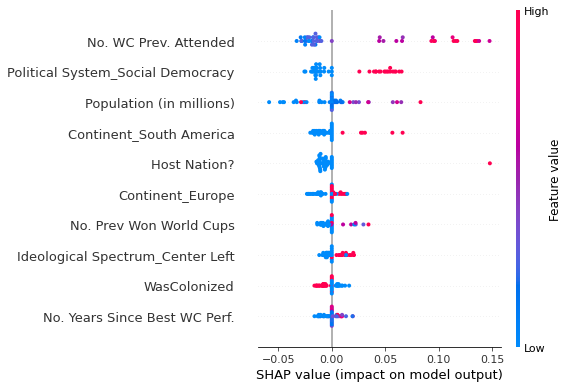

In [137]:
train = pd.read_csv('group_stage_X_train.csv')
explainer = shap.KernelExplainer(group_stage_model.predict_proba, train[group_stage_model.feature_names])

# Calculate SHAP values (this can take some time depending on the model complexity and data size)
shap_values = explainer.shap_values(gs[group_stage_model.feature_names], nsamples=100)  # nsamples is adjustable based on your computation resources

indices_keep = []
cols_keep = []
for index, i in enumerate(group_stage_model.feature_names):
    if '_home' not in i:
        indices_keep.append(index)
        if '_away' in i:
            cols_keep.append(i[:-5])
        else:
            cols_keep.append(i)
columns_keep = np.array(group_stage_model.feature_names)[indices_keep]
shap_values_keep = np.array([i[indices_keep] for i in shap_values[2]])

# Plot the beeswarm plot for the class of interest (e.g., class 2 for win)
shap.summary_plot(shap_values_keep, gs[columns_keep], feature_names=cols_keep, plot_type="dot", max_display=10)

Using 458 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/16 [00:00<?, ?it/s]

Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.717e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 82 iterations, alpha=6.135e-03, previous alpha=6.135e-03, with an active set of 39 regressors.
Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.717e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 85 iterations, alpha=6.131e-03, previous alpha=6.131e-03, with an active set of 38 regressors.


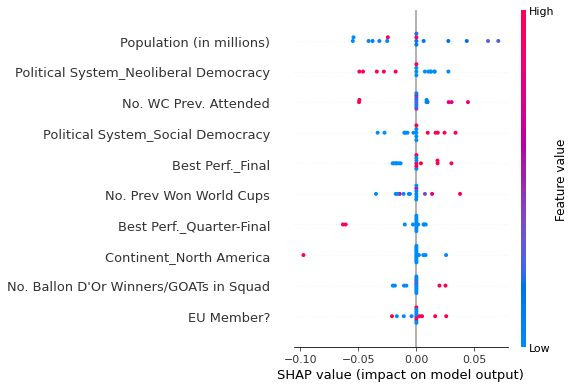

In [138]:
train = pd.read_csv('ko_stage_X_train.csv')
explainer = shap.KernelExplainer(ko_stage_model.predict_proba, train[ko_stage_model.feature_names])

# Calculate SHAP values (this can take some time depending on the model complexity and data size)
shap_values = explainer.shap_values(ko[ko_stage_model.feature_names], nsamples=100) # nsamples is adjustable based on your computation resources

indices_keep = []
cols_keep = []
for index, i in enumerate(ko_stage_model.feature_names):
    if '_home' not in i:
        indices_keep.append(index)
        if '_away' in i:
            cols_keep.append(i[:-5])
        else:
            cols_keep.append(i)
columns_keep = np.array(ko_stage_model.feature_names)[indices_keep]
shap_values_keep = np.array([i[indices_keep] for i in shap_values[1]])

# Plot the beeswarm plot for the class of interest (e.g., class 1 for binary classification)
shap.summary_plot(shap_values_keep, ko[columns_keep], feature_names=cols_keep, plot_type="dot", max_display=10)

# Prepare Tournament Simulator

In [100]:
# Create colonization dictionary
colonizer_dict = {}
colonizer_dict['Belgium'] = ['Zaire']
colonizer_dict['England'] = ['Australia','Canada','Egypt','Ghana','Iran','Iraq','Ireland','Israel','Jamaica','New Zealand','Nigeria','Nortern Ireland','Qatar','Scotland','South Africa','Trinidad and Tobago','United Arab Emirates','United States','Wales']
colonizer_dict['France'] = ['Algeria','Cameroon','Haiti','Ivory Coast','Morocco','Senegal','Togo','Tunisia']
colonizer_dict['Netherlands'] = ['Dutch East Indies']
colonizer_dict['Portugal'] = ['Angola','Brazil']
colonizer_dict['Spain'] = ['Argentina','Bolivia','Chile','Colombia','Costa Rica','Cuba','Ecuador','El Salvador','Honduras','Mexico','Panama','Paraguay','Peru','Uruguay']

In [101]:
# Helper function that returns a row vector for a KO stage match given 2 teams and the stage at which they play
def getRowVector(home_team, away_team, stage):
    filt_ht = test[test['Home Team Name'] == home_team]
    drop = []
    for i in filt_ht.columns:
        if '_home' not in i:
            drop.append(i)
    filt_ht = filt_ht.drop(columns=drop)
    filt_ht = filt_ht.head(1)
    filt_ht = filt_ht.reset_index(drop=True)
    filt_at = test[test['Away Team Name'] == away_team]
    drop = []
    for i in filt_at.columns:
        if '_away' not in i:
            drop.append(i)
    filt_at = filt_at.drop(columns=drop)
    filt_at = filt_at.head(1)
    filt_at = filt_at.reset_index(drop=True)
    big = pd.concat([filt_ht, filt_at], axis=1)
    big['GroupStage'] = [0]
    if stage == 'R16':
        big['R16'] = [1]
        big['QF'] = [0]
        big['SF'] = [0]
        big['F'] = [0]
        big['PO3'] = [0]
    elif stage == 'QF':
        big['R16'] = [0]
        big['QF'] = [1]
        big['SF'] = [0]
        big['F'] = [0]
        big['PO3'] = [0]
    elif stage == 'SF':
        big['R16'] = [0]
        big['QF'] = [0]
        big['SF'] = [1]
        big['F'] = [0]
        big['PO3'] = [0]
    elif stage == 'F':
        big['R16'] = [0]
        big['QF'] = [0]
        big['SF'] = [0]
        big['F'] = [1]
        big['PO3'] = [0]
    elif stage == 'PO3':
        big['R16'] = [0]
        big['QF'] = [0]
        big['SF'] = [0]
        big['F'] = [0]
        big['PO3'] = [1]
    if home_team in colonizer_dict.keys() and away_team in colonizer_dict[home_team]:
        big['Home_Colonized_Away'] = [1]
        big['Away_Colonized_Home'] = [0]
    elif away_team in colonizer_dict.keys() and home_team in colonizer_dict[away_team]:
        big['Home_Colonized_Away'] = [0]
        big['Away_Colonized_Home'] = [1]
    else:
        big['Home_Colonized_Away'] = [0]
        big['Away_Colonized_Home'] = [0]
    return big[ko_stage_model.feature_names]

In [102]:
# Helper function that applies the KO stage model model to an input row vector
def testGame(game_vec, model=ko_stage_model):
    game_vec = game_vec[ko_stage_model.feature_names]
    y_prob = model.predict_proba(game_vec)[0]
    result = np.random.choice(['Home Win', 'Away Win'], p=y_prob)
    return result

In [103]:
# Get only group stage matches
test_group_stage = test[test['Stage'].str.contains('Group')]
test_group_stage.shape

(48, 113)

In [104]:
# Set X_test such that it only contains features from the group stage model
X_test = test_group_stage[group_stage_model.feature_names]
X_test.shape

(48, 54)

In [106]:
# Set number of simulations
n_simulations = 10000
# Put teams in the same groups that they were in at the tournament's start
group_stage_dict = {'Group A':['Netherlands','Senegal','Ecuador','Qatar'], 'Group B':['England','United States','Iran','Wales'], 
              'Group C':['Argentina','Poland','Saudi Arabia','Mexico'], 'Group D':['France','Australia','Tunisia','Denmark'],
              'Group E':['Japan','Spain','Germany','Costa Rica'], 'Group F':['Morocco','Croatia','Belgium','Canada'],
              'Group G':['Brazil','Switzerland','Cameroon','Serbia'],'Group H':['Portugal','South Korea','Uruguay','Ghana']}
#Initialize team result dictionaries
team_result_dict = {}
team_group_result_dict = {}
for i in test['Home Team Name'].unique():
    team_result_dict[i] = []
    team_group_result_dict[i] = []
for i in test['Away Team Name'].unique():
    team_result_dict[i] = []
    team_group_result_dict[i] = []
#Start simulation
for i in tqdm(np.arange(n_simulations)):
    #Initialize group stage performance dictionary
    team_sim_group = {}
    for x in test['Home Team Name'].unique():
        team_sim_group[x] = 0
    for x in test['Away Team Name'].unique():
        team_sim_group[x] = 0
    #Iterate through all group stage games
    for index, row in test_group_stage.iterrows():
        ht = row['Home Team Name']
        at = row['Away Team Name']
        group = row['Stage']
        row_vector = X_test.loc[index:index]
        y_prob = group_stage_model.predict_proba(row_vector)[0]
        result = np.random.choice(['Home Win', 'Draw', 'Away Win'], p=y_prob)
        if result == 'Home Win':
            team_sim_group[ht] += 3
        elif result == 'Draw':
            team_sim_group[ht] += 1
            team_sim_group[at] += 1
        else:
            team_sim_group[at] += 3
    for x in team_sim_group.keys():
        val = team_sim_group[x]
        lista = team_group_result_dict[x]
        lista.append(val)
        team_group_result_dict[x] = lista
    #Return group results (who are the top 2 teams per group?). In case of tie, select tied teams based off random choice)
    group_results = {}
    for x in group_stage_dict.keys():
        lista = group_stage_dict[x]
        dicta = {}
        for y in lista:
            dicta[y] = team_sim_group[y]
        df = pd.DataFrame()
        df['Team'] = dicta.keys()
        df['Points'] = dicta.values()
        df = df.sort_values('Points', ascending=False)
        top = df[df['Points'] == max(dicta.values())]
        if len(top) == 1:
            tup = [top['Team'].tolist()[0]]
            second = df[df['Points'] < max(dicta.values())]
            max_val = second['Points'].max()
            second = second[second['Points'] == max_val]
            if len(second) == 1:
                tup.append(second['Team'].tolist()[0])
            else:
                list(np.random.choice(second['Team'].tolist()))
                tup.append(np.random.choice(second['Team'].tolist()))
        elif len(top) > 1:
            tup = list(np.random.choice(top['Team'].tolist(), size=2, replace=False))
        group_results[x] = tup
    #For teams that did not make it out of group stage, append 'Group' result to their result dictionary
    for x in team_result_dict.keys():
        isin = False
        for y in group_results.keys():
            if x in group_results[y]:
                isin=True
                break
        if not isin:
            lista = team_result_dict[x]
            lista.append('Group')
            team_result_dict[x] = lista
    #Start Round of 16
    r16_dict = {}
    ##Game 1
    ht = group_results['Group A'][0]
    at = group_results['Group B'][1]
    game_vec = getRowVector(ht, at, 'R16')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('R16')
        team_result_dict[at] = lista
        r16_dict['Game 1'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('R16')
        team_result_dict[ht] = lista
        r16_dict['Game 1'] = at
    ##Game 2
    ht = group_results['Group C'][0]
    at = group_results['Group D'][1]
    game_vec = getRowVector(ht, at, 'R16')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('R16')
        team_result_dict[at] = lista
        r16_dict['Game 2'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('R16')
        team_result_dict[ht] = lista
        r16_dict['Game 2'] = at
    ##Game 3
    ht = group_results['Group E'][0]
    at = group_results['Group F'][1]
    game_vec = getRowVector(ht, at, 'R16')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('R16')
        team_result_dict[at] = lista
        r16_dict['Game 3'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('R16')
        team_result_dict[ht] = lista
        r16_dict['Game 3'] = at
    ##Game 4
    ht = group_results['Group G'][0]
    at = group_results['Group H'][1]
    game_vec = getRowVector(ht, at, 'R16')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('R16')
        team_result_dict[at] = lista
        r16_dict['Game 4'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('R16')
        team_result_dict[ht] = lista
        r16_dict['Game 4'] = at
    ##Game 5
    ht = group_results['Group B'][0]
    at = group_results['Group A'][1]
    game_vec = getRowVector(ht, at, 'R16')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('R16')
        team_result_dict[at] = lista
        r16_dict['Game 5'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('R16')
        team_result_dict[ht] = lista
        r16_dict['Game 5'] = at
    ##Game 6
    ht = group_results['Group D'][0]
    at = group_results['Group C'][1]
    game_vec = getRowVector(ht, at, 'R16')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('R16')
        team_result_dict[at] = lista
        r16_dict['Game 6'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('R16')
        team_result_dict[ht] = lista
        r16_dict['Game 6'] = at
    ##Game 7
    ht = group_results['Group F'][0]
    at = group_results['Group E'][1]
    game_vec = getRowVector(ht, at, 'R16')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('R16')
        team_result_dict[at] = lista
        r16_dict['Game 7'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('R16')
        team_result_dict[ht] = lista
        r16_dict['Game 7'] = at
    ##Game 8
    ht = group_results['Group H'][0]
    at = group_results['Group G'][1]
    game_vec = getRowVector(ht, at, 'R16')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('R16')
        team_result_dict[at] = lista
        r16_dict['Game 8'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('R16')
        team_result_dict[ht] = lista
        r16_dict['Game 8'] = at
    #QF
    qf_dict = {}
    ##Game 1
    ht = r16_dict['Game 1']
    at = r16_dict['Game 2']
    game_vec = getRowVector(ht, at, 'QF')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('QF')
        team_result_dict[at] = lista
        qf_dict['Game 1'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('QF')
        team_result_dict[ht] = lista
        qf_dict['Game 1'] = at
    ##Game 2
    ht = r16_dict['Game 3']
    at = r16_dict['Game 4']
    game_vec = getRowVector(ht, at, 'QF')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('QF')
        team_result_dict[at] = lista
        qf_dict['Game 2'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('QF')
        team_result_dict[ht] = lista
        qf_dict['Game 2'] = at
    ##Game 3
    ht = r16_dict['Game 5']
    at = r16_dict['Game 6']
    game_vec = getRowVector(ht, at, 'QF')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('QF')
        team_result_dict[at] = lista
        qf_dict['Game 3'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('QF')
        team_result_dict[ht] = lista
        qf_dict['Game 3'] = at
    ##Game 4
    ht = r16_dict['Game 7']
    at = r16_dict['Game 8']
    game_vec = getRowVector(ht, at, 'QF')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('QF')
        team_result_dict[at] = lista
        qf_dict['Game 4'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('QF')
        team_result_dict[ht] = lista
        qf_dict['Game 4'] = at
    #SF
    sf_dict = {}
    sf_dict_l = {}
    ##Game 1
    ht = qf_dict['Game 1']
    at = qf_dict['Game 2']
    game_vec = getRowVector(ht, at, 'SF')
    result = testGame(game_vec)
    if result == 'Home Win':
        sf_dict['Game 1'] = ht
        sf_dict_l['Game 1'] = at
    else:
        sf_dict['Game 1'] = at
        sf_dict_l['Game 1'] = ht
    ##Game 2
    ht = qf_dict['Game 3']
    at = qf_dict['Game 4']
    game_vec = getRowVector(ht, at, 'SF')
    result = testGame(game_vec)
    if result == 'Home Win':
        sf_dict['Game 2'] = ht
        sf_dict_l['Game 2'] = at
    else:
        sf_dict['Game 2'] = at
        sf_dict_l['Game 2'] = ht
    #PO3
    ht = sf_dict_l['Game 1']
    at = sf_dict_l['Game 2']
    game_vec = getRowVector(ht, at, 'PO3')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[ht]
        lista.append('3rd')
        team_result_dict[ht] = lista
        lista = team_result_dict[at]
        lista.append('4th')
        team_result_dict[at] = lista
    else:
        lista = team_result_dict[at]
        lista.append('3rd')
        team_result_dict[at] = lista
        lista = team_result_dict[ht]
        lista.append('4th')
        team_result_dict[ht] = lista
    #F
    ht = sf_dict['Game 1']
    at = sf_dict['Game 2']
    game_vec = getRowVector(ht, at, 'F')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[ht]
        lista.append('1st')
        team_result_dict[ht] = lista
        lista = team_result_dict[at]
        lista.append('2nd')
        team_result_dict[at] = lista
    else:
        lista = team_result_dict[at]
        lista.append('1st')
        team_result_dict[at] = lista
        lista = team_result_dict[ht]
        lista.append('2nd')
        team_result_dict[ht] = lista

100%|█████████████████████████████████████| 10000/10000 [38:00<00:00,  4.38it/s]


In [107]:
# Show outcome table - this table gives us the probability of each team finishing in each stage
win = []
ru = []
third = []
fourth = []
qf = []
r16 = []
g = []
for i in team_result_dict.keys():
    lista = team_result_dict[i]
    gc = 0
    r16c = 0
    qfc = 0
    fourthc = 0
    thirdc = 0
    ruc = 0
    winc = 0
    for x in lista:
        if x == 'Group':
            gc += 1
        elif x == 'R16':
            r16c += 1
        elif x == 'QF':
            qfc += 1
        elif x == '4th':
            fourthc += 1
        elif x == '3rd':
            thirdc += 1
        elif x == '2nd':
            ruc += 1
        elif x == '1st':
            winc += 1
    win.append(winc)
    ru.append(ruc)
    third.append(thirdc)
    fourth.append(fourthc)
    qf.append(qfc)
    r16.append(r16c)
    g.append(gc)
result_df = pd.DataFrame()
result_df['Team'] = team_result_dict.keys()
result_df['Group'] = np.array(g)/n_simulations
result_df['R16'] = np.array(r16)/n_simulations
result_df['QF'] = np.array(qf)/n_simulations
result_df['4th Place'] = np.array(fourth)/n_simulations
result_df['3rd Place'] = np.array(third)/n_simulations
result_df['2nd Place'] = np.array(ru)/n_simulations
result_df['Winner'] = np.array(win)/n_simulations
result_df.sort_values('Winner', ascending=False)

,Team,Group,R16,QF,4th Place,3rd Place,2nd Place,Winner
7,France,0.2790,0.1481,0.1206,0.0371,0.0958,0.1051,0.2143
9,Germany,0.2011,0.1801,0.1392,0.0511,0.1136,0.1139,0.2010
10,Spain,0.1616,0.2133,0.1885,0.0592,0.1123,0.1247,0.1404
4,Argentina,0.1261,0.3189,0.1777,0.0569,0.1008,0.1026,0.1170
1,England,0.1964,0.2127,0.2794,0.0812,0.0889,0.0816,0.0598
17,Netherlands,0.1757,0.2450,0.2856,0.0779,0.0822,0.0765,0.0571
12,Brazil,0.1347,0.3102,0.3198,0.0568,0.0715,0.0557,0.0513
13,Portugal,0.2654,0.2576,0.2854,0.0523,0.0492,0.0561,0.0340
11,Belgium,0.2308,0.4532,0.1266,0.0517,0.0526,0.0521,0.0330
15,Uruguay,0.2077,0.3202,0.2989,0.0583,0.0475,0.0441,0.0233


In [108]:
# Define multiclass brier score metric
def scoringMetric(y_true,y_pred):
    if type(y_true)  == list:
        y_true = np.array(y_true)
    n_classes = y_pred.shape[1]
    y_true_one_hot = np.eye(n_classes)[y_true.astype(int)]

    # Calculate the squared differences
    squared_diff = (y_true_one_hot - y_pred) ** 2

    # Calculate the mean squared difference
    score = np.mean(np.sum(squared_diff, axis=1))

    return score

In [112]:
# Initialize a dictionary with each team's true finish position: [Group stage, R16, QF, SF, F]
y_true_dict= {'Qatar':[1,0,0,0,0],
               'England':[0,0,1,0,0],
               'Senegal':[0,1,0,0,0],
               'United States':[0,1,0,0,0],
               'Argentina':[0,0,0,0,1],
               'Denmark':[1,0,0,0,0],
               'Mexico':[1,0,0,0,0],
               'France':[0,0,0,0,1],
               'Morocco':[0,0,0,1,0],
               'Germany':[1,0,0,0,0],
               'Spain':[0,1,0,0,0],
               'Belgium':[1,0,0,0,0],
               'Brazil':[0,0,1,0,0],
               'Portugal':[0,0,1,0,0],
               'Switzerland':[0,1,0,0,0],
               'Uruguay':[1,0,0,0,0],
               'Wales':[1,0,0,0,0],
               'Netherlands':[0,0,1,0,0],
               'Tunisia':[1,0,0,0,0],
               'Poland':[0,1,0,0,0],
               'Japan':[0,1,0,0,0],
               'Croatia':[0,0,0,1,0],
               'Cameroon':[1,0,0,0,0],
               'South Korea':[0,1,0,0,0],
               'Ecuador':[1,0,0,0,0],
               'Iran':[1,0,0,0,0],
               'Australia':[0,1,0,0,0],
               'Saudi Arabia':[1,0,0,0,0],
               'Canada':[1,0,0,0,0],
               'Costa Rica':[1,0,0,0,0],
               'Serbia':[1,0,0,0,0],
               'Ghana':[1,0,0,0,0]}
result_df_eval = result_df.copy()
result_df_eval['SF'] = result_df_eval['4th Place'] + result_df_eval['3rd Place']
result_df_eval['F'] = result_df_eval['2nd Place'] + result_df_eval['Winner']
result_df_eval = result_df_eval[['Team','Group','R16','QF','SF','F']]
y_prob = []
y_true = []
y_pred = []
for _, row in result_df_eval.iterrows():
    t = row['Team']
    g = row['Group']
    r16 = row['R16']
    qf = row['QF']
    sf = row['SF']
    f = row['F']
    probs = [g,r16,qf,sf,f]
    max_val = max(probs)
    if f == max_val:
        pred = [0,0,0,0,1]
    elif sf == max_val:
        pred = [0,0,0,1,0]
    elif qf == max_val:
        pred = [0,0,1,0,0]
    elif r16 == max_val:
        pred = [0,1,0,0,0]
    elif g == max_val:
        pred = [1,0,0,0,0]
    y_pred.append(pred)
    y_true.append(y_true_dict[t])
    y_prob.append(probs)
y_true = np.array(y_true)
y_true_bin = np.array([np.argmax(i) for i in y_true])
y_prob = np.array(y_prob)
y_pred = np.array(y_pred)
y_pred_bin = np.array([np.argmax(i) for i in y_pred])
# Print performance metrics 
print('Accuracy: ', accuracy_score(y_true, y_pred))
print('Brier Score: ', scoringMetric(y_true_bin, y_prob))
print('Log Loss: ', log_loss(y_true, y_prob))
print()

Accuracy:  0.59375
Brier Score:  0.602901135625
Log Loss:  1.1266045832116185



In [115]:
# Create a simulation result table that shows the probabilities of each team reaching each stage of the tournament (exception: probability for group stage = 
# probability of getting KO'd in group stage)
result_df_eval['R16'] = 1 - result_df_eval['Group']
result_df_eval['QF'] = result_df_eval['QF'] + result_df_eval['SF'] + result_df_eval['F']
result_df_eval['SF'] = result_df_eval['SF'] + result_df_eval['F']
result_df_eval['Winner'] = result_df['Winner']
result_df_eval.sort_values('Winner', ascending=False)

,Team,Group,R16,QF,SF,F,Winner
7,France,0.2790,0.7210,0.5729,0.4523,0.3194,0.2143
9,Germany,0.2011,0.7989,0.6188,0.4796,0.3149,0.2010
10,Spain,0.1616,0.8384,0.6251,0.4366,0.2651,0.1404
4,Argentina,0.1261,0.8739,0.5550,0.3773,0.2196,0.1170
1,England,0.1964,0.8036,0.5909,0.3115,0.1414,0.0598
17,Netherlands,0.1757,0.8243,0.5793,0.2937,0.1336,0.0571
12,Brazil,0.1347,0.8653,0.5551,0.2353,0.1070,0.0513
13,Portugal,0.2654,0.7346,0.4770,0.1916,0.0901,0.0340
11,Belgium,0.2308,0.7692,0.3160,0.1894,0.0851,0.0330
15,Uruguay,0.2077,0.7923,0.4721,0.1732,0.0674,0.0233


In [116]:
# Calculate Brier score for market odds and of simulated odds of a team passing the group stage
pass_gs_betting_odds = {'Netherlands':[-1000,1],
                        'Senegal':[-141,1],
                        'Ecuador':[100,0],
                        'Qatar':[400,0],
                        'England':[-2000, 1],
                        'United States':[100,1],
                        'Wales':[110,0],
                        'Iran':[300,0],
                        'Argentina':[-1786, 1],
                        'Mexico':[-125,0],
                        'Poland':[100,1],
                        'Saudi Arabia':[700,0],
                        'France':[-1786,1],
                        'Denmark':[-333,0],
                        'Tunisia':[100,0],
                        'Australia':[400,1],
                        'Spain':[-1613,1],
                        'Germany':[-1000,0],
                        'Japan':[330,1],
                        'Costa Rica':[800,0],
                        'Belgium':[-1000,0],
                        'Croatia':[-250,1],
                        'Morocco':[200,1],
                        'Canada':[300,0],
                        'Brazil':[-1613,1],
                        'Serbia':[-110,0],
                        'Switzerland':[-110,1],
                        'Cameroon':[350,0],
                        'Portugal':[-752,1],
                        'Uruguay':[-250,0],
                        'South Korea':[250,1],
                        'Ghana':[275,0]}
error_odds = 0
error_sims = 0
for i in pass_gs_betting_odds.keys():
    tup = pass_gs_betting_odds[i]
    odds = tup[0]
    res = tup[1]
    if odds > 0:
        prob = 100/(odds+100)
    else:
        prob = -odds/(100-odds)
    error_odds += (prob-res)**2
    filt = result_df_eval[result_df_eval['Team'] == i]
    prob = filt['R16'].tolist()[0]
    error_sims += (prob-res)**2
print('Betting Odds Error:', error_odds/len(pass_gs_betting_odds))
print('Simulation Error:', error_sims/len(pass_gs_betting_odds))

Betting Odds Error: 0.23683453038331143
Simulation Error: 0.225916041875


In [117]:
#Use simulated group stage results to fill out most likely bracket
gs_df = pd.DataFrame()
gs_df['Team'] = team_group_result_dict.keys()
gs_df['Mean Points'] = [np.mean(i) for i in team_group_result_dict.values()]
group_lista = []
for i in gs_df['Team'].tolist():
    for x in group_stage_dict.keys():
        if i in group_stage_dict[x]:
            group_lista.append(x)
            break
gs_df['Group'] = group_lista
gs_df = gs_df.sort_values(['Group', 'Mean Points'], ascending=[True,False])
gs_df

,Team,Mean Points,Group
17,Netherlands,6.0848,Group A
0,Qatar,4.1593,Group A
24,Ecuador,3.4547,Group A
2,Senegal,2.9318,Group A
1,England,5.8225,Group B
3,United States,4.4508,Group B
16,Wales,3.3202,Group B
25,Iran,2.5391,Group B
4,Argentina,6.4767,Group C
6,Mexico,5.1886,Group C


In [118]:
def testGame2(game_vec, model=ko_stage_model):
    game_vec = game_vec[ko_stage_model.feature_names]
    y_prob = model.predict_proba(game_vec)[0]
    return y_prob

In [119]:
#R16
## Game 1
game_vec = getRowVector('Netherlands', 'United States', 'R16')
print(testGame2(game_vec))
print()
## Game 2
game_vec = getRowVector('Argentina', 'Denmark', 'R16')
print(testGame2(game_vec))
print()
## Game 3
game_vec = getRowVector('Spain', 'Croatia', 'R16')
print(testGame2(game_vec))
print()
## Game 4
game_vec = getRowVector('Brazil', 'Portugal', 'R16')
print(testGame2(game_vec))
print()
## Game 5
game_vec = getRowVector('England', 'Qatar', 'R16')
print(testGame2(game_vec))
print()
## Game 6
game_vec = getRowVector('France', 'Mexico', 'R16')
print(testGame2(game_vec))
print()
## Game 7
game_vec = getRowVector('Belgium', 'Germany', 'R16')
print(testGame2(game_vec))
print()
## Game 8
game_vec = getRowVector('Uruguay', 'Switzerland', 'R16')
print(testGame2(game_vec))

[0.91847083 0.08152917]

[0.79153347 0.20846653]

[0.75374775 0.24625225]

[0.5356988 0.4643012]

[0.76668774 0.23331226]

[0.95427705 0.04572295]

[0.29078958 0.70921042]

[0.77561548 0.22438452]


In [120]:
# Netherlands, Argentina, Spain, Brazil, England, France, Germany, and Uruguay pass to the QFs
#QF
## Game 1
game_vec = getRowVector('Netherlands', 'Argentina', 'QF')
print(testGame2(game_vec))
print()
## Game 2
game_vec = getRowVector('Spain', 'Brazil', 'QF')
print(testGame2(game_vec))
print()
## Game 3
game_vec = getRowVector('England', 'France', 'QF')
print(testGame2(game_vec))
print()
## Game 4
game_vec = getRowVector('Germany', 'Uruguay', 'QF')
print(testGame2(game_vec))

[0.45436853 0.54563147]

[0.64010192 0.35989808]

[0.3015828 0.6984172]

[0.78375709 0.21624291]


In [121]:
# Argentina, Spain, France, and Germany pass to the SFs
#SF
## Game 1
game_vec = getRowVector('Argentina', 'Spain', 'SF')
print(testGame2(game_vec))
print()
## Game 2
game_vec = getRowVector('France', 'Germany', 'SF')
print(testGame2(game_vec))

[0.53469931 0.46530069]

[0.572843 0.427157]


In [122]:
# Argentina and France pass to the Final
#F
game_vec = getRowVector('Argentina', 'France', 'SF')
print(testGame2(game_vec))

[0.38930071 0.61069929]


In [ ]:
# France is the expected winner